In [7]:
from typing import Dict, TypedDict, List, Annotated, Sequence
from langgraph.graph import StateGraph, START, END, add_messages
from langchain_core.messages import BaseMessage, HumanMessage, ToolMessage, AIMessage

In [10]:
from langgraph.prebuilt import ToolNode
from langchain_core.tools import tool
from langchain_huggingface.embeddings import HuggingFaceEmbeddings
from langchain_qdrant import QdrantVectorStore
from langchain_ollama import ChatOllama

In [4]:
class Agentstate(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]

In [5]:

# Node 1 - to parse html file and store only the html sections
def parse_html():
    """This node will parse the html file, create chunks and store the chunks in a collection in vector DB"""
    return "Success"

# Node 2 - to parse style section in the html
def parse_css():
    """This node will parse the css section (style section), create chunks and store the chunks in a collection in vector DB"""
    return "Success"

# Node 3 - to parse script section in the html
def parse_js():
    """This node will parse the javascript section (script section), create chunks and store the chunks in a collection in vector DB"""
    return "Success"


In [12]:
@tool 
def fetch_html_context():
    """Use this tool to fetch the relevant html sections related to user query and pass it to AI model for modification"""


@tool
def fetch_css_context():
    """Use this tool to fetch the css classes or styles used in the html in case the user query requires changes in css section"""

@tool
def fetch_js_context():
    """Use this tool to fetch the javascript functions used in html in case the user query requires changes in javascript section"""



In [14]:
tools = [fetch_html_context, fetch_css_context, fetch_js_context]

llm = ChatOllama(base_url="http://localhost:11434/",model="qwen2.5-coder:1.5b",
    temperature=0
).bind_tools(tools=tools)

In [6]:
# Add a system prompt and tell the AI to use the tools to fetch relevant data and specify the output format
def call_llm(state: Agentstate):
    """This node will call the AI model with the user query"""
    return {"messages": ["success"]}


# This is the conditional edge - check the last message, if it requires a tool call, return continue. Else return next
def should_continue():
    """This node will decide whether to loop through the tools or move to the next step in the graph"""
    return "continue"

In [15]:
def parse_output():
    """This node will replace the html, css and js sections in the vector DB and if any new sections are added then, it will add them in vector DB"""


def render_html():
    """This node will merge the chunks in the vector DB into final html file"""



In [19]:
graph = StateGraph(Agentstate)
graph.add_node("parse_html", parse_html)
graph.add_node("parse_css", parse_css)
graph.add_node("parse_js", parse_js)
graph.add_node("call_model", call_llm)
tool_node = ToolNode(tools=tools)
graph.add_node("tool_node", tool_node)
graph.add_node("parse_output", parse_output)

graph.add_edge(START, "parse_html")
graph.add_edge("parse_html", "parse_css")
graph.add_edge("parse_css", "parse_js")
graph.add_edge("parse_js", "call_model")


graph.add_conditional_edges(
    "call_model",
    should_continue,
    {
        "continue": "tool_node",
        "next": "parse_output"
    }
)

graph.add_edge("tool_node", "call_model")
graph.add_node("render_html", render_html)
graph.add_edge("parse_output", "render_html")
graph.add_edge("render_html", END)

agent = graph.compile()

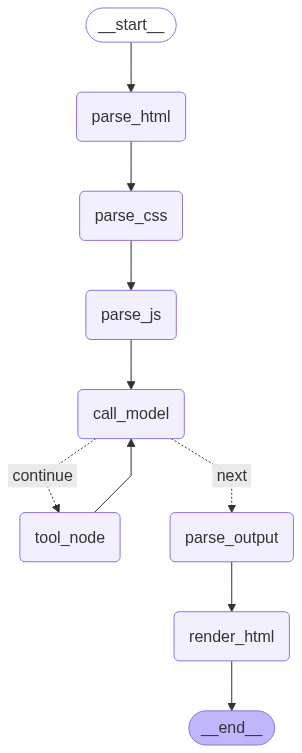

In [20]:
from IPython.display import Image, display
display(Image(agent.get_graph().draw_mermaid_png()))